#Introduction

We have a series of tasks where we use deep learning to solve them all. These tasks are different from each other so we can apply different methods of the package keras (https://keras.io) to solve them in different ways.

##Task 1: We will run a multilayer perceptron on the iris dataset using the keras Sequential interface. We will include code of the models using GridSearchCV.

First, we need to initialize the tensorflow session to run faster the code we will make for this task.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras


init = tf.global_variables_initializer()
sess.run(init)


Using TensorFlow backend.


Now, we will obtain some statistics data from our dataset to see how to manage it. Also, we will make use of some plots to see clarily how is related our data from each other.

In [3]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
#how many elements are in species
unique, counts = np.unique(iris['species'], return_counts=True)
print(dict(zip(unique, counts)))

{'setosa': 50, 'versicolor': 50, 'virginica': 50}


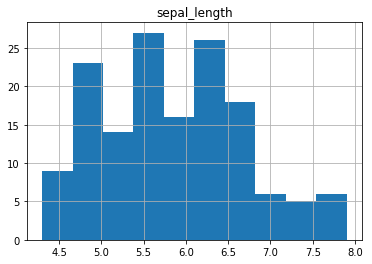

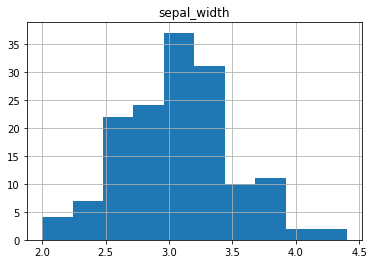

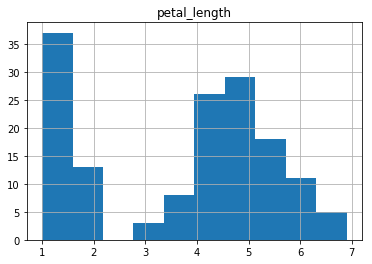

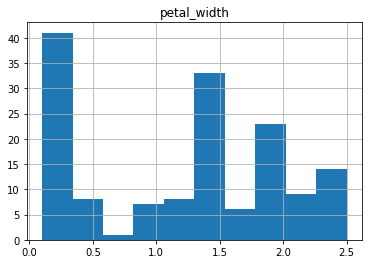

In [6]:
feat=['sepal_length','sepal_width','petal_length','petal_width']
for i in feat:
    iris.hist(column=i)

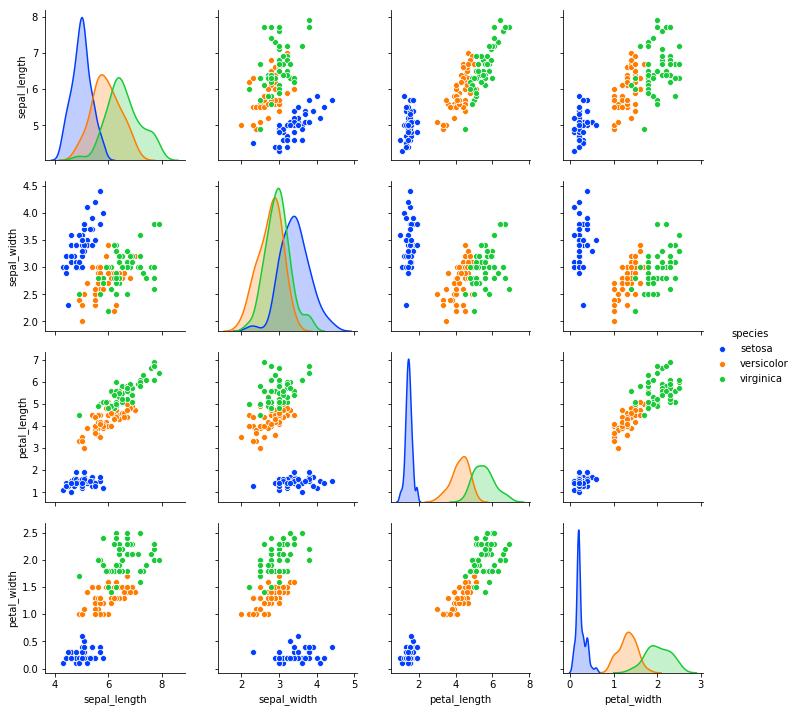

In [7]:

sns.pairplot(iris, hue="species",palette="bright")
plt.show()

Now, we will split the data in X and y to develop our model. Then, we will see a graphic using TSNE algorithm to realize if the three classes can be easily splitted in different groups.

In [8]:
iris = iris.sample(frac=1).reset_index(drop=True)
X= iris.iloc[:, 0:4].values


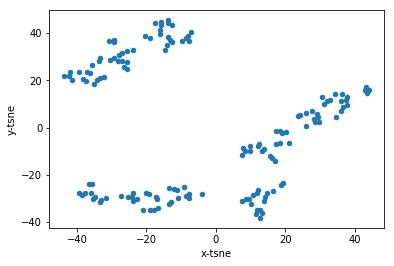

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity= 6)
tsne_results = tsne.fit_transform(X)
iris['x-tsne'] = tsne_results[:,0]
iris['y-tsne'] = tsne_results[:,1]
iris.plot('x-tsne','y-tsne',kind='scatter')

In [10]:
# Encoded the column y
iris['target'] = iris.species.astype('category').cat.codes
y = iris['target'].values

We need to split our data in training set and test set to have some data to test our model and see how good it is. Take in mind we will use a regularizer for our model, which allow to apply penalties on layer parameters or layer activity during optimization.  In our case, we will use bias_regularizer.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

def make_model():
    
    model = Sequential()
    model.add(Dense(12, input_dim=4, activation='relu')) # first hidden layer
    
    model.add(Dense(64, activation='relu',bias_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1)))
    model.add(Dense(32, activation='relu',bias_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1)))
    model.add(Dense(16, activation='relu',bias_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1)))
    model.add(Dense(3, activation='softmax')) 
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.20, random_state=1)


In [14]:
from keras.wrappers.scikit_learn import KerasClassifier


batch_size = [80, 100]
epochs = [10,50]
param_grid = dict(batch_size=batch_size, nb_epoch=epochs)

k_model = KerasClassifier(make_model)

clf = GridSearchCV(estimator=k_model, param_grid=param_grid, 
                               cv=cv)


In [50]:
# Fit the model
clf_fitted=clf.fit(X_train, y_train)

Epoch 1/1
96/96 [==============================] - 0s 42us/step
Epoch 1/1
96/96 [==============================] - 0s 73us/step
Epoch 1/1
96/96 [==============================] - 0s 83us/step
Epoch 1/1
96/96 [==============================] - 0s 62us/step
Epoch 1/1
96/96 [==============================] - 0s 83us/step
Epoch 1/1
96/96 [==============================] - 0s 83us/step
Epoch 1/1
96/96 [==============================] - 0s 83us/step
Epoch 1/1
96/96 [==============================] - 0s 73us/step
Epoch 1/1
96/96 [==============================] - 0s 73us/step
Epoch 1/1
96/96 [==============================] - 0s 83us/step
Epoch 1/1
96/96 [==============================] - 0s 42us/step
Epoch 1/1
96/96 [==============================] - 0s 109us/step
Epoch 1/1
96/96 [==============================] - 0s 90us/step
Epoch 1/1
96/96 [==============================] - 0s 77us/step
Epoch 1/1
96/96 [==============================] - 0s 42us/step
Epoch 1/1
96/96 [======================

In [51]:
print("The best parameters are %s with a score of %0.2f"
      % (clf_fitted.best_params_, clf_fitted.best_score_))

The best parameters are {'batch_size': 100, 'nb_epoch': 50} with a score of 0.43


We obtain not a good model, with a 0.43 of accuracy. This is because we only possess a data of 150 rows, not so much, so we can't do a better model.

In [53]:
from sklearn.metrics import confusion_matrix
pred = clf_fitted.predict(X_test)
confusion_matrix(y_test, pred)

array([[ 0,  0,  9],
       [ 0,  0, 12],
       [ 0,  0,  9]], dtype=int64)

In [55]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.3

Even using the test dataset, we obtain an accuracy of 0.3. One method to improve the accuracy of our model is to use Bootstrap. In our case, we are going to use AdaBoostClassifier.

In [13]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import AdaBoostClassifier

ann_estimator = KerasClassifier(build_fn= make_model, epochs=50, batch_size=100)

boosted_ann = AdaBoostClassifier(base_estimator= ann_estimator,n_estimators=5,random_state=1)
boosted_ann.fit(X_train, y_train)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
120/120 [==============================] - 10s 83ms/step - loss: 0.0103 - acc: 0.4083
Epoch 2/50
120/120 [==============================] - 0s 83us/step - loss: 0.0110 - acc: 0.6167
Epoch 3/50
120/120 [==============================] - 0s 83us/step - loss: 0.0145 - acc: 0.3417
Epoch 4/50
120/120 [==============================] - 0s 66us/step - loss: 0.0115 - acc: 0.3667
Epoch 5/50
120/120 [==============================] - 0s 83us/step - loss: 0.0116 - acc: 0.3667
Epoch 6/50
120/120 [==============================] - 0s 83us/step - loss: 0.0123 - acc: 0.3750
Epoch 7/50
120/120 [==============================] - 0s 75us/step - loss: 0.0116 - acc: 0.3583
Epoch 8/50
120/120 [==============================] - 0s 75us/step - loss: 0.0099 - acc: 0.3833
Epoch 9/50
120/120 [==============================] - 0s 74us/step - loss: 0.0110 - acc: 0.3667
Epoch 10/50
120

120/120 [==============================] - 0s 75us/step - loss: 0.0064 - acc: 0.9667
Epoch 30/50
120/120 [==============================] - 0s 83us/step - loss: 0.0059 - acc: 0.9333
Epoch 31/50
120/120 [==============================] - 0s 91us/step - loss: 0.0064 - acc: 0.8833
Epoch 32/50
120/120 [==============================] - 0s 83us/step - loss: 0.0057 - acc: 0.8833
Epoch 33/50
120/120 [==============================] - 0s 83us/step - loss: 0.0059 - acc: 0.9250
Epoch 34/50
120/120 [==============================] - 0s 83us/step - loss: 0.0052 - acc: 0.9667
Epoch 35/50
120/120 [==============================] - 0s 75us/step - loss: 0.0057 - acc: 0.9667
Epoch 36/50
120/120 [==============================] - 0s 91us/step - loss: 0.0052 - acc: 0.9250
Epoch 37/50
120/120 [==============================] - 0s 83us/step - loss: 0.0052 - acc: 0.9167
Epoch 38/50
120/120 [==============================] - 0s 91us/step - loss: 0.0047 - acc: 0.9500
Epoch 39/50
120/120 [=====================

120/120 [==============================] - 0s 83us/step - loss: 0.0072 - acc: 0.9500
Epoch 14/50
120/120 [==============================] - 0s 83us/step - loss: 0.0062 - acc: 0.9500
Epoch 15/50
120/120 [==============================] - 0s 75us/step - loss: 0.0069 - acc: 0.9333
Epoch 16/50
120/120 [==============================] - 0s 108us/step - loss: 0.0058 - acc: 0.9417
Epoch 17/50
120/120 [==============================] - 0s 91us/step - loss: 0.0063 - acc: 0.9167
Epoch 18/50
120/120 [==============================] - 0s 75us/step - loss: 0.0055 - acc: 0.9417
Epoch 19/50
120/120 [==============================] - 0s 91us/step - loss: 0.0060 - acc: 0.9500
Epoch 20/50
120/120 [==============================] - 0s 75us/step - loss: 0.0052 - acc: 0.9500
Epoch 21/50
120/120 [==============================] - 0s 83us/step - loss: 0.0056 - acc: 0.9083
Epoch 22/50
120/120 [==============================] - 0s 83us/step - loss: 0.0048 - acc: 0.8917
Epoch 23/50
120/120 [====================

120/120 [==============================] - 0s 83us/step - loss: 0.0052 - acc: 0.6583
Epoch 48/50
120/120 [==============================] - 0s 75us/step - loss: 0.0048 - acc: 0.6583
Epoch 49/50
120/120 [==============================] - 0s 75us/step - loss: 0.0050 - acc: 0.6583
Epoch 50/50
120/120 [==============================] - 0s 83us/step - loss: 0.0047 - acc: 0.6583


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000002202F0A9C88>,
          learning_rate=1.0, n_estimators=5, random_state=1)

In [14]:
boosted_ann.score(X_train,y_train)

0.95

In [15]:
pred_ann=boosted_ann.predict(X_test)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_ann)

array([[11,  0,  0],
       [ 0, 10,  0],
       [ 0,  3,  6]], dtype=int64)

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred_ann)

0.9

As you can see, our model has a huge improvement more than 100%.

##Task 2: We will use the MNIST dataset and we will construct another traditional multilayer perceptron model.

In [18]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
%matplotlib inline

In [20]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

mnist_images = mnist.train.images
mnist_labels = mnist.train.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [21]:
mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x000002203F50AB70>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x000002203F50A278>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x000002203F50AEF0>)

In [23]:
mnist_images.shape

(55000, 784)

In [22]:
mnist_labels.shape

(55000,)

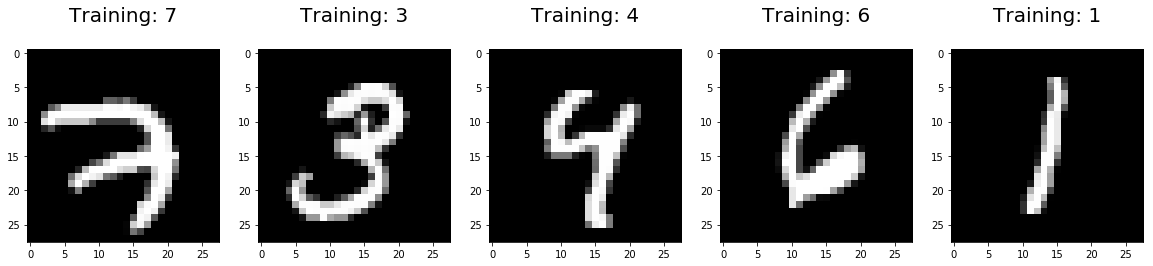

In [8]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(mnist_images[0:5], mnist_labels[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

In [6]:
from keras.utils import to_categorical
# one hot encode
mnist_labels_encoded = to_categorical(mnist_labels)

In [7]:
from sklearn.model_selection import train_test_split
train_img, test_img, train_lbl, test_lbl = train_test_split(
    mnist_images, mnist_labels_encoded, test_size=0.25, random_state=0)

In [9]:
train_img.shape


(41250, 784)

In [11]:
model = Sequential()
model.add(Dense(128, input_dim=784, activation='relu')) # first hidden layer

model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax')) 
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(train_img, train_lbl, epochs=10, batch_size=128)


Epoch 1/10
41250/41250 [==============================] - 40s 961us/step - loss: 0.4098 - acc: 0.8834
Epoch 2/10
41250/41250 [==============================] - 3s 65us/step - loss: 0.1563 - acc: 0.9530
Epoch 3/10
41250/41250 [==============================] - 3s 63us/step - loss: 0.1099 - acc: 0.9677
Epoch 4/10
41250/41250 [==============================] - 3s 64us/step - loss: 0.0834 - acc: 0.9756
Epoch 5/10
41250/41250 [==============================] - 3s 64us/step - loss: 0.0616 - acc: 0.9811
Epoch 6/10
41250/41250 [==============================] - 3s 66us/step - loss: 0.0489 - acc: 0.9851
Epoch 7/10
41250/41250 [==============================] - 3s 65us/step - loss: 0.0407 - acc: 0.9872
Epoch 8/10
41250/41250 [==============================] - 3s 63us/step - loss: 0.0318 - acc: 0.9903
Epoch 9/10
41250/41250 [==============================] - 3s 63us/step - loss: 0.0270 - acc: 0.9912
Epoch 10/10
41250/41250 [==============================] - 3s 63us/step - loss: 0.0207 - acc: 0.99

<h4> Model using Drop Out

Because our dataset contains 55000 images, it is good enough to make a good model. Above we can see we obtained an accuracy of 0.9937. Sometimes, because we are using deep learning models, it could occur that our model is overfitting. A technique to avoid this is to use Dropout, which will randomly select a fraction of our dataset to 0 and won't be considered as a data in each layer of our model.

In [12]:

from keras.layers import Dropout

model_do = Sequential()
model_do.add(Dense(128, input_dim=784, activation='relu'))
model_do.add(Dropout(p=0.1))
model_do.add(Dense(64, activation='relu'))
model_do.add(Dropout(p=0.1))
model_do.add(Dense(64, activation='relu'))
model_do.add(Dropout(p=0.1))
model_do.add(Dense(10, activation='softmax')) 
# Compile model
model_do.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_do.fit(train_img, train_lbl, epochs=10, batch_size=5)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\alex_\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  
C:\Users\alex_\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  
C:\Users\alex_\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/10
41250/41250 [==============================] - 120s 3ms/step - loss: 0.3210 - acc: 0.9032
Epoch 2/10
41250/41250 [==============================] - 73s 2ms/step - loss: 0.1684 - acc: 0.9509
Epoch 3/10
41250/41250 [==============================] - 75s 2ms/step - loss: 0.1359 - acc: 0.9606
Epoch 4/10
41250/41250 [==============================] - 75s 2ms/step - loss: 0.1169 - acc: 0.9666
Epoch 5/10
41250/41250 [==============================] - 74s 2ms/step - loss: 0.1065 - acc: 0.9698
Epoch 6/10
41250/41250 [==============================] - 75s 2ms/step - loss: 0.0961 - acc: 0.9714
Epoch 7/10
41250/41250 [==============================] - 75s 2ms/step - loss: 0.0892 - acc: 0.9747
Epoch 8/10
41250/41250 [==============================] - 75s 2ms/step - loss: 0.0847 - acc: 0.9766
Epoch 9/10
41250/41250 [==============================] - 72s 2ms/step - loss: 0.0803 - acc: 0.9779
Epoch 10/10
41250/41250 [==============================] - 71s 2ms/step - loss: 0.0739 - acc: 0.978

Even using Dropout function in our model, we obtained a good accuracy in our model (0.9788). That's because the amount of data in our model. In deep learning, it is beneficial having a lot of data to construct a good model.

##Task 3: We will train a convolutional neural network on the SVHN dataset (http://ufldl.stanford.edu/housenumbers/) in format 2 (single digit classification)

A convolutional neural network is a different approach we used before. This method is perfect to use with images. Before we used a mnist dataset which was already converted in an array. Here, we are using images with colors (and other features such as shadows, brightness, etc), and we know in some cases, the model should consider colors to make a good classification.

In [24]:
import scipy.io
mat = scipy.io.loadmat('C:/Users/alex_/Desktop/college/DS630-MachineLear/train_32x32.mat',struct_as_record=False)
mat_test = scipy.io.loadmat('C:/Users/alex_/Desktop/college/DS630-MachineLear/test_32x32.mat',struct_as_record=False)

print(sorted(mat.keys()))
print(sorted(mat_test.keys()))

['X', '__globals__', '__header__', '__version__', 'y']
['X', '__globals__', '__header__', '__version__', 'y']


In [25]:
X_train=mat["X"]
y_train=mat["y"]

X_test=mat_test["X"]
y_test=mat_test["y"]

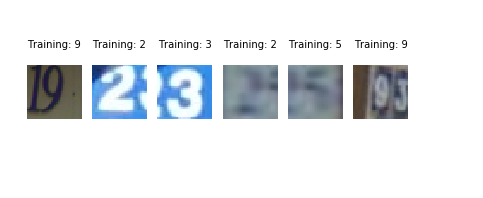

In [26]:
plt.figure(figsize=(8,3))
for index, (image, label) in enumerate(zip(X_train[0:7], y_train[0:7])):
    imgplot = plt.imshow(X_train[:,:,:,index])
    plt.title('Training: %i\n' % label, fontsize = 10)
    plt.subplot(1,7,index+1)
    plt.axis('off')
    
plt.show()

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(32, 32, 3, 73257)
(73257, 1)
(32, 32, 3, 26032)
(26032, 1)


In [8]:
#how many elements are in species
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 9: 4659, 10: 4948}


The class number 10 is because we are also considering zeros, so we need to change it.

In [9]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [10]:

X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

In [15]:
from keras.utils import to_categorical
# one hot encode
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print(y_train_encoded.shape)
print(y_test_encoded.shape)

(73257, 10)
(26032, 10)


In [16]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense,Dropout

In [17]:
# Initialising the CNN
classifier_cnn = Sequential()

# Step 1 - Convolution
classifier_cnn.add(Conv2D(32, (3, 3), input_shape = (32, 32, 3), activation = 'relu'))

# Step 2 - Pooling
classifier_cnn.add(MaxPooling2D(pool_size = (2, 2)))

classifier_cnn.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier_cnn.add(MaxPooling2D(pool_size = (2, 2)))

classifier_cnn.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier_cnn.add(MaxPooling2D(pool_size = (2, 2)))



# Step 3 - Flattening
classifier_cnn.add(Flatten())

# Step 4 - Full connection

classifier_cnn.add(Dense(units = 64, activation = 'relu'))
classifier_cnn.add(Dropout(0.2))
classifier_cnn.add(Dense(units = 64, activation = 'relu'))
classifier_cnn.add(Dropout(0.2))
classifier_cnn.add(Dense(units = 10, activation = 'softmax'))

# Compiling the CNN
classifier_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
classifier_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

After creating our model, we need to create our ImageDataGenerator, which allows to make a configuration for image data preparation and augmentation. This function have different parameters which is good to know (https://keras.io/preprocessing/image/). Here, we are using the default parameters we found in the documentation.

In [19]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range=0.08,
    rotation_range=8,
    width_shift_range=0.2,
    height_shift_range=0.2)
test_gen = ImageDataGenerator(rescale = 1./255)

train_generator = datagen.flow(X_train, y_train_encoded, batch_size=64)
test_generator = test_gen.flow(X_test, y_test_encoded, batch_size=64)

<h4> Base CNN model

In [20]:

classifier_cnn.fit_generator(train_generator, validation_data=test_generator,
                             steps_per_epoch=6000, epochs=5,validation_steps=1000)


Instructions for updating:
Use tf.cast instead.
Epoch 1/5
6000/6000 [==============================] - 148s 25ms/step - loss: 1.2945 - acc: 0.5683 - val_loss: 0.5052 - val_acc: 0.8491
Epoch 2/5
6000/6000 [==============================] - 134s 22ms/step - loss: 0.7995 - acc: 0.7504 - val_loss: 0.4488 - val_acc: 0.8645
Epoch 3/5
6000/6000 [==============================] - 136s 23ms/step - loss: 0.7090 - acc: 0.7807 - val_loss: 0.3742 - val_acc: 0.8876
Epoch 4/5
6000/6000 [==============================] - 136s 23ms/step - loss: 0.6703 - acc: 0.7932 - val_loss: 0.3582 - val_acc: 0.8932
Epoch 5/5
6000/6000 [==============================] - 135s 22ms/step - loss: 0.6425 - acc: 0.8023 - val_loss: 0.3547 - val_acc: 0.8936


Again we obtained a good model with an accuracy of 0.8936. However, to train this model took a lot of time. One method to reduce the running time is to add BatchNormalization layers in our model. 

<h4> Building a CNN Model using Batch Normalization

In [21]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization

In [23]:
# Initialising the CNN
classifier_cnn_2 = Sequential()

# Step 1 - Convolution
classifier_cnn_2.add(Conv2D(32, (3, 3), input_shape = (32, 32, 3), activation = 'relu'))
classifier_cnn_2.add(BatchNormalization(axis=-1))
# Step 2 - Pooling
classifier_cnn_2.add(MaxPooling2D(pool_size = (2, 2)))


classifier_cnn_2.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier_cnn_2.add(BatchNormalization(axis=-1))
classifier_cnn_2.add(MaxPooling2D(pool_size = (2, 2)))


classifier_cnn_2.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier_cnn_2.add(BatchNormalization(axis=-1))
classifier_cnn_2.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier_cnn_2.add(Flatten())

# Step 4 - Full connection
classifier_cnn_2.add(Dense(units = 128, activation = 'relu'))
classifier_cnn_2.add(BatchNormalization(axis=-1))
classifier_cnn_2.add(Dropout(0.2))
classifier_cnn_2.add(Dense(units = 10, activation = 'softmax'))

# Compiling the CNN
classifier_cnn_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


classifier_cnn_2.fit_generator(train_generator, validation_data=test_generator,
                             steps_per_epoch=6000, epochs=5,validation_steps=1000)


Epoch 1/5
6000/6000 [==============================] - 168s 28ms/step - loss: 0.9495 - acc: 0.6934 - val_loss: 0.3878 - val_acc: 0.8875
Epoch 2/5
6000/6000 [==============================] - 136s 23ms/step - loss: 0.5948 - acc: 0.8149 - val_loss: 0.3200 - val_acc: 0.9073
Epoch 3/5
6000/6000 [==============================] - 136s 23ms/step - loss: 0.5359 - acc: 0.8332 - val_loss: 0.3082 - val_acc: 0.9113
Epoch 4/5
6000/6000 [==============================] - 136s 23ms/step - loss: 0.5067 - acc: 0.8432 - val_loss: 0.3416 - val_acc: 0.9019
Epoch 5/5
6000/6000 [==============================] - 137s 23ms/step - loss: 0.4830 - acc: 0.8509 - val_loss: 0.2963 - val_acc: 0.9162


Clearly it took less of running time to finalize the training, and again we obtained a good model with an accuracy of 0.91

##Task 4: We will load the weights of a pre-trained convolutional neural network included in keras, see https://keras.io/applications/ , and use it as feature extraction method to train another model. Use the pets dataset found in http://www.robots.ox.ac.uk/~vgg/data/pets/

In this case, we are using VGG16 model.

In [4]:
image_size=224
from keras.applications.vgg16 import VGG16
model_4 = VGG16(weights='imagenet', include_top=False,classes=38)

model_4.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
bloc

In [5]:
listNames=pd.read_csv('C:/Users/alex_/Desktop/college/DS630-MachineLear/images.tar/list.txt', sep=" ", header=None, error_bad_lines=False)

b'Skipping line 5: expected 5 fields, saw 10\nSkipping line 6: expected 5 fields, saw 8\n'


In [6]:
listNames.head(8)

,0,1,2,3,4
0,#Image,CLASS-ID,SPECIES,BREED,ID
1,#ID:,1:37,Class,ids,NaN
2,#SPECIES:,1:Cat,2:Dog,NaN,NaN
3,#BREED,ID:,1-25:Cat,1:12:Dog,NaN
4,Abyssinian_100,1,1,1,NaN
5,Abyssinian_101,1,1,1,NaN
6,Abyssinian_102,1,1,1,NaN
7,Abyssinian_103,1,1,1,NaN


In [7]:
listNames.describe()

,0,1,2,3,4
count,7353,7353,7353,7352,1
unique,7353,41,6,28,1
top,chihuahua_25,36,2,9,ID
freq,1,200,4978,400,1


In [6]:
listNames.columns = ['name', 'type','a','b','c']

In [7]:
listNames=listNames.drop(listNames.index[[0,1,2,3]])
listNames = listNames.drop('a', 1)
listNames = listNames.drop('b', 1)
listNames = listNames.drop('c', 1)

In [10]:
print(listNames.type.unique())   #different types of animals

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37']


In [8]:
import os
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

img_list = []

num=0
y=[]
for filename in os.listdir('C:/Users/alex_/Desktop/college/DS630-MachineLear/images.tar/images'):
    num=num+1
    #if (num==10):
    #    break
    if filename.endswith(".jpg"): 

        
        img = image.load_img('C:/Users/alex_/Desktop/college/DS630-MachineLear/images.tar/images/'+filename, target_size=(224, 224))
        
        pos_dot=filename.find('.')
        filename2=filename[0:pos_dot]
        if (num==10000):
            print(filename2)
        frame=listNames.loc[listNames['name'] == filename2]
        
        val=frame.iloc[:,1].values
        
        if(not val):
            continue;
        else:
            y=np.append(y,val[0])
            
        
        
        
        img_data = image.img_to_array(img)
        #print(img_data.shape)
        #img_data = np.expand_dims(img_data, axis=0)

        img_list.append(img_data)
        
        
img_list_np = np.array(img_list)
print(img_list_np.shape)




C:\Users\alex_\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


(7275, 224, 224, 3)


In [9]:
# Freeze the layers except the last 4 layers
for layer in model_4.layers[:-4]:
    layer.trainable = False
# Check the trainable status of the individual layers
for layer in model_4.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001B8D03E34E0> False
<keras.layers.convolutional.Conv2D object at 0x000001B8D1DC2390> False
<keras.layers.convolutional.Conv2D object at 0x000001B8BEC19208> False
<keras.layers.pooling.MaxPooling2D object at 0x000001B8D5A909B0> False
<keras.layers.convolutional.Conv2D object at 0x000001B8D5A90978> False
<keras.layers.convolutional.Conv2D object at 0x000001B8FD11AC18> False
<keras.layers.pooling.MaxPooling2D object at 0x000001B8FD132F60> False
<keras.layers.convolutional.Conv2D object at 0x000001B8FD132E80> False
<keras.layers.convolutional.Conv2D object at 0x000001B8FD164780> False
<keras.layers.convolutional.Conv2D object at 0x000001B8FD197B70> False
<keras.layers.pooling.MaxPooling2D object at 0x000001B8FD1AED30> False
<keras.layers.convolutional.Conv2D object at 0x000001B8FD1AEB00> False
<keras.layers.convolutional.Conv2D object at 0x000001B8FD1E6898> False
<keras.layers.convolutional.Conv2D object at 0x000001B8FD1FBEF0> False
<ker

In [10]:
from keras.applications.vgg16 import preprocess_input
vgg16_feature_list=[]
for imgx in img_list_np:
    img_data = np.expand_dims(imgx, axis=0)

    img_data = preprocess_input(img_data)



    vgg16_feature = model_4.predict(img_data)

    vgg16_feature_np = np.array(vgg16_feature)

    vgg16_feature_list.append(vgg16_feature_np.flatten())
    
vgg16_feature_list_np = np.array(vgg16_feature_list)

Above, in the last variable (vgg16_feature_list_np), we obtained the weights of our model, and with it we can use another model to make the predictions in our test dataset.

In [12]:
from keras.utils import to_categorical
print(y.shape)
y_encoded = to_categorical(y)
print(y_encoded.shape)

(7275,)
(7275, 38)


In [15]:
from keras.models import Sequential
from keras.layers import Dense

output_nodes=38

model_tk4 = Sequential()
model_tk4.add(Dense(1024, input_dim=25088, activation='relu')) # first hidden layer

model_tk4.add(Dense(512, activation='relu'))
model_tk4.add(Dense(256, activation='relu'))
model_tk4.add(Dense(128, activation='relu'))
model_tk4.add(Dense(output_nodes, activation='softmax')) 
# Compile model
model_tk4.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model_tk4.fit(vgg16_feature_list_np, y_encoded, epochs=20, batch_size=64)


Epoch 1/20
7275/7275 [==============================] - 11s 2ms/step - loss: 5.3897 - acc: 0.4010
Epoch 2/20
7275/7275 [==============================] - 2s 296us/step - loss: 0.5825 - acc: 0.8216
Epoch 3/20
7275/7275 [==============================] - 2s 295us/step - loss: 0.1624 - acc: 0.9487
Epoch 4/20
7275/7275 [==============================] - 2s 297us/step - loss: 0.0423 - acc: 0.9911
Epoch 5/20
7275/7275 [==============================] - 2s 296us/step - loss: 0.0075 - acc: 1.0000
Epoch 6/20
7275/7275 [==============================] - 2s 297us/step - loss: 0.0033 - acc: 1.0000
Epoch 7/20
7275/7275 [==============================] - 2s 297us/step - loss: 0.0023 - acc: 1.0000
Epoch 8/20
7275/7275 [==============================] - 2s 297us/step - loss: 0.0019 - acc: 1.0000
Epoch 9/20
7275/7275 [==============================] - 2s 297us/step - loss: 0.0015 - acc: 1.0000
Epoch 10/20
7275/7275 [==============================] - 2s 298us/step - loss: 0.0013 - acc: 1.0000
Epoch 11/2

We need to read the test dataset and then use it in our model we constructed above.

In [16]:

img_list_test = []

num=0
y_test=[]
for filename in os.listdir('C:/Users/alex_/Desktop/college/DS630-MachineLear/images.tar/images_test'):

    if filename.endswith(".jpg"): 

        
        img = image.load_img('C:/Users/alex_/Desktop/college/DS630-MachineLear/images.tar/images_test/'+filename, target_size=(224, 224))
        
        pos_dot=filename.find('.')
        filename2=filename[0:pos_dot]
        
        frame=listNames.loc[listNames['name'] == filename2]
        
        val=frame.iloc[:,1].values
        
        if(not val):
            continue;
        else:
            y_test=np.append(y_test,val[0])
            
        
        
        
        img_data = image.img_to_array(img)
        #print(img_data.shape)
        #img_data = np.expand_dims(img_data, axis=0)

        img_list_test.append(img_data)
        
        
img_list_np_test = np.array(img_list_test)
print(img_list_np_test.shape)




(74, 224, 224, 3)


In [17]:
y_test_encoded = to_categorical(y_test)
print(y_test_encoded.shape)

(74, 38)


In [18]:
from keras.applications.vgg16 import preprocess_input
vgg16_feature_list_test=[]
for imgx in img_list_np_test:
    img_data = np.expand_dims(imgx, axis=0)

    img_data = preprocess_input(img_data)



    vgg16_feature = model_4.predict(img_data)

    vgg16_feature_np = np.array(vgg16_feature)

    vgg16_feature_list_test.append(vgg16_feature_np.flatten())
    
vgg16_feature_list_np_test = np.array(vgg16_feature_list_test)

In [19]:
predictions=model_tk4.predict(vgg16_feature_list_np_test)

In [20]:
predictions

array([[8.9563720e-08, 8.8464892e-01, 4.2988638e-08, ..., 1.5554915e-11,
        1.2540657e-11, 5.1354387e-08],
       [1.6823810e-08, 9.9999821e-01, 1.8474460e-11, ..., 2.1937636e-10,
        5.1224982e-15, 1.4252803e-11],
       [1.5001750e-07, 9.8109998e-10, 7.7974491e-02, ..., 8.3620921e-02,
        8.7683771e-10, 6.7451357e-12],
       ...,
       [3.9758058e-11, 2.6749236e-14, 1.5431955e-13, ..., 1.5958128e-12,
        9.9999166e-01, 6.8620793e-09],
       [2.7552567e-17, 8.4953034e-14, 2.2138547e-22, ..., 3.1650738e-14,
        1.6963933e-13, 1.0000000e+00],
       [3.1492574e-16, 9.3937047e-15, 1.0747636e-24, ..., 1.4521975e-14,
        1.6771321e-09, 1.0000000e+00]], dtype=float32)

As the result of the prediction, we obtained probabilities of each class, we need the maximum number of each row and then we will compare with the truth values.

In [21]:
y_pred=[]
for list_x in predictions:
    num=max(list_x)
    index=list_x.tolist().index(num)
    y_pred.append(index)

In [23]:
y_pred_mat=np.zeros((len(y_pred), 38))
ind=0
for i in y_pred:
    y_pred_mat[ind][i]=1
    ind=ind+1

In [26]:
from sklearn.metrics import confusion_matrix,accuracy_score
accuracy_score(y_test_encoded,y_pred_mat)


0.8243243243243243

Finally, we see that we obtained an accuracy of 0.82.